<a href="https://colab.research.google.com/github/bokutachi256/gisday2019/blob/master/4_Wetness_index%E3%81%A8STI%E3%81%AE%E8%A8%88%E7%AE%97.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Wetness indexとSTIの計算

* GIS Day in 東京 2019 Eコース
* Pythonを用いたDEM処理
* 首都大学東京 都市環境学部 地理環境学科 中山大地
* 2019年12月21日 首都大学東京 南大沢キャンパス

# はじめに

この節ではWetness IndexとSTI（Sediment Transport Index）を求めます．
どちらも任意の点の傾斜量とその点より上流の流域面積から求めることができます．

流域面積を求めるには流路網処理が必要になります．
手順としては以下になります．

1. すべてのメッシュで流下方向を求める
1. 流下方向をもとに流域面積（Flow Accumulation）を求める

これらは複雑な計算が必要ですが，`pysheds`ライブラリを使うことにより
簡単に求めることができます．


# ライブラリのインストール

標準ではGoogle Colaboratoryに用意されていないライブラリ（`pysheds`）を，マジックコマンドでpipを使ってインストールします．
マジックコマンドはGoogle Colaboratory上でUNIXのコマンドを実行する方法です．


In [2]:
%pip install pysheds

     |████████████████████████████████| 61kB 2.0MB/s 
     |████████████████████████████████| 10.1MB 7.9MB/s 
     |████████████████████████████████| 18.0MB 233kB/s 
  Created wheel for pysheds: filename=pysheds-0.2.6-cp36-none-any.whl size=50621 sha256=007b3c167f1eeb4fa08ef4a4f4f3d558b9c4d6fe7436658626ba38417f2e7379
  Stored in directory: /root/.cache/pip/wheels/cf/a4/54/b913b8685cd8579ea02f9e115061a5dfd200449ef36698d7c0
Successfully built pysheds


# ライブラリのインポート

このプログラムでは，以下のライブラリを使用します．

* `numpy`: 多次元配列計算のライブラリ．
* `matplotlib.pyplot`: グラフ作成・データ可視化ライブラリ．
* `matplotlib.colors`: カラーライブラリ．
* `pysheds`：流路網・流域処理のライブラリ．GeoTiffの読み書きにも使用．
* `google.colab`: Google Colaboratory用ライブラリ．google driveのマウントに使用．


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from pysheds.grid import Grid
from google.colab import drive

/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:422: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  projstring = _prepare_from_string(projparams)
/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:422: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  projstring = _prepare_from_string(projparams)
/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:422: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  projstring = _prepare_from_string(projparams)
/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:422: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  projstring = _prepare_from_string(projparams)
/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:422: FutureWarning: '+i

# Google Driveのマウント


`drive.mount`を使ってGoogle DriveをGoogle Colaboratoryにマウントします．
`drive.mount`の引数はGoogle Colaboratory内のマウントポイントです．
このマウントポイントで示されたディレクトリにGoogle Driveのルートディレクトリ（マイドライブ）が接続されます．

`drive.mount`が実行されると，どのGoogleアカウントで接続するか聞かれます．
適切なアカウントを指定してアクセス権を与えます．
その後認証コードが発行されますので，それをコピーしてテキストボックスにペーストしてください．
これでGoogle Driveがマウントされます．

マイドライブの中に作業用のディレクトリ`gisday2019`を作成してください．
この作業用ディレクトリへのフルパスは`/drive/My Drive/gisday2019`になります．
これを変数`base_dir`に格納しておきます．

In [4]:
drive.mount('/content/drive')
base_dir = "/content/drive/My Drive/gisday2019/"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# DEMと傾斜量の読み込み


`pysheds`の`Grid`オブジェクトを使ってDEMと傾斜量のGeoTiffを読み込みます．
`Grid.from_raster`を使うと
インスタンスの生成とGeoTiffの読み込みが同時にできます．
第一引数は読み込むGeoTiffのファイル名，第二引数はインスタンス内での名前です．
DEMと傾斜量の二つを読み込みますので，
インスタンス名はそれぞれ`demgrid`と`slopegrid`にしました．
標高値と傾斜量はそれぞれ`demgrid.dem`と`slopegrid.slope`でアクセスできます

In [0]:
demgrid = Grid.from_raster(base_dir + 'miyake_dem_JGD2011_zone9.tif', data_name = 'dem')
dem = demgrid.dem
slopegrid = Grid.from_raster(base_dir + 'miyake_slope_JGD2011_zone9.tif', data_name = 'slope')
slope = slopegrid.slope

# 流域面積の計算


Flow Accumulationの計算には以下の手順が必要になります．
これらは`pysheds`の機能で求めることができます．

1. すべてのメッシュで流下方向を求める
1. 流下方向をもとに流域面積（Flow Accumulation）を求める

## DEMの凹陥地と平坦地の処理

流下方向の基本的な求め方は，
任意のメッシュの周囲の8点を見て下方向に最も傾斜が急な方向をたどっていくものです．
しかし離散化の都合でDEM必ず凹陥地が発生し，
そこで流路網が終了してしまいます．
また，完全に平坦な部分では最大流下方向が求まらないため，
流路のループや交差が発生する可能性があります．

これらの矛盾を含まない完全な流路網を求めるには，
凹陥地と平坦地の処理が必要です．

`pysheds`には凹陥地を処理する`fill_depressions`メソッドと
平坦地を処理する`resolve_flats`メソッドがあり，
これらを使うと上記の処理が簡単にできます．



凹陥地を埋める`fill_depression`メソッドの引数は2個です．
引数`data`は凹陥地処理対象となるオブジェクトを指定し，ここでは`dem`になります．
引数`out_name`は処理済みDEMの出力先で，ここでは`flooded_dem`にしました．

次に`flooded_dem`‘に対して平坦地処理を行います．
`resolve_flats`‘も引数が2個あり，
引数`data`が平坦地処理の対象データ，
引数`out_name`が処理済みDEMの出力先です．
処理の対象は`flooded_dem`‘，
出力先は`inflated_dem`にしました．

以上で凹陥地と平坦地が処理された`demgrid.inflated_dem`が求まります．



In [6]:
demgrid.fill_depressions(data = 'dem', out_name = 'flooded_dem')
demgrid.resolve_flats(data = 'flooded_dem', out_name = 'inflated_dem')

/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:422: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  projstring = _prepare_from_string(projparams)
/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:422: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  projstring = _prepare_from_string(projparams)



確認のためオリジナルのDEMと処理済みDEMの差分を表示してみましょう．

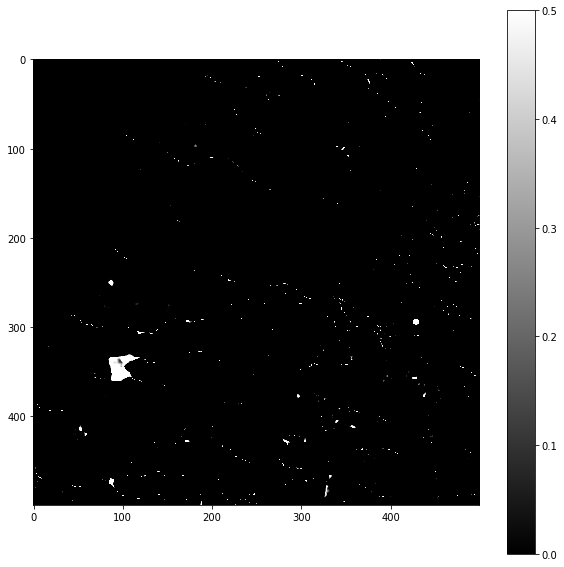

In [8]:
plt.figure(figsize = (10,10))
im = plt.imshow((demgrid.inflated_dem - demgrid.dem)[500:1000, 2000:2500], cmap = "gray", vmax = 0.5)
plt.colorbar(im)
plt.show()

## 流下方向の計算

DEMの準備ができたので，流下方向を計算します．
流下方向の計算には流下方向マップが必要です．
これは流下方向の8方位をどのような値で表すかです．
ArcGISでは以下のような値になっています．

流下方向|北|北東|東|南東|南|南西|西|北西
-:|-:|-:|-:|-:|-:|-:|-:|-:
dirmap|64|128|1|2|4|8|16|32

今回は`pysheds`でも同じ値を使います．
流下方向マップをタプル`dirmap`に格納します．

In [0]:
#N    NE    E    SE    S    SW    W    NW
dirmap = (64, 128, 1, 2, 4, 8, 16, 32)

次に`flowdir`メソッドを使って流下方向を計算します．
引数`data`は処理対象のDEMですので`inflated_dem`を，
引数`out_name`は求まった流下方向の出力先で`dir`を指定しました．
引数`dirmap`は流下方向マップで，
引数`routing`は流下方法のタイプになります．
通常は8方位の流下方向を用いますので`d8`にします．

In [10]:
demgrid.flowdir(data = 'inflated_dem', out_name = 'dir', dirmap = dirmap, routing = 'd8')

/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:422: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  projstring = _prepare_from_string(projparams)


この計算はDEMが大きいとそれなりに時間がかかります．
計算が終わったら図化して確認してみましょう．

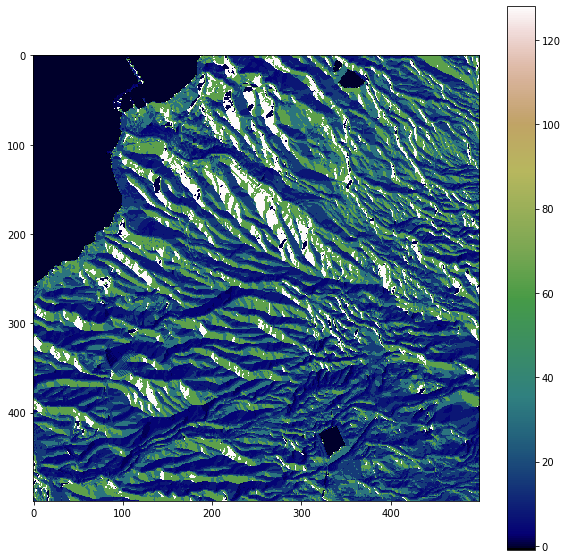

In [12]:
plt.figure(figsize = (10,10))
im = plt.imshow(demgrid.dir[500:1000, 2000:2500], cmap = "gist_earth")
plt.colorbar(im)
plt.show()

## 流域面積（flow accuulation）の計算

流域面積（flow accumulation） $S(c_i)$ は以下の式で定義できます．

$$
\begin{eqnarray}
  S(c_i) &=& S(c_i)+\sum_u^n{S(c_u)}\\
\end{eqnarray}
$$

$S(c_u)$は任意のメッシュ$c_i$の上流メッシュの面積を表します．
すなわち$\sum_u^n{S(c_u)}$は任意のメッシュ$c_i$よりも上流部の合計面積になります．

`accumulation`メソッドを使って流域面積（flow accumulation）を計算します．

In [13]:
demgrid.accumulation(data = 'dir', dirmap = dirmap, out_name = 'acc')
demgrid.acc.dtype

/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:422: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  projstring = _prepare_from_string(projparams)


dtype('int64')

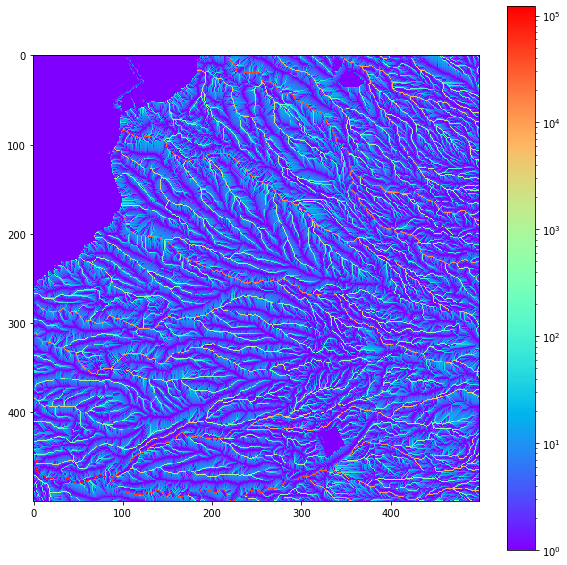

In [0]:
plt.figure(figsize = (10,10))
im = plt.imshow(demgrid.acc[500:1000, 2000:2500], cmap = "rainbow", norm=colors.LogNorm(1, demgrid.acc.max()))
plt.colorbar(im)
plt.show()

In [0]:
demgrid.acc.dtype

dtype('int64')

In [0]:
# float64で保存してみると保存できる
demgrid.add_gridded_data(data = demgrid.acc.astype(np.float64), data_name = 'acc', affine = demgrid.affine, crs = demgrid.crs, nodata = 0)
demgrid.to_raster('acc', base_dir + 'acc.tif', view=False)

# Wetness Indexの計算


Wetness Indexは以下の式で求まります．


wetnessindex=ln(As[面積]/tanβ[傾斜])


田谷さんの計算では

np.log(grid.acc/slope_dg)

になっていたが，傾斜をタンジェントに置き換えた．

wetnessindex=np.log(grid.acc/slope)


In [0]:
#wetnessindex=np.log(grid.acc.astype(np.float32)/grid.slope.astype(np.float32))
wetnessindex = np.log(demgrid.acc / slopegrid.slope)

wetnessindex[wetnessindex == np.inf] = -9999
wetnessindex[wetnessindex == -np.inf] = -9999
#wetnessindex[wetnessindex==np.nan]=0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


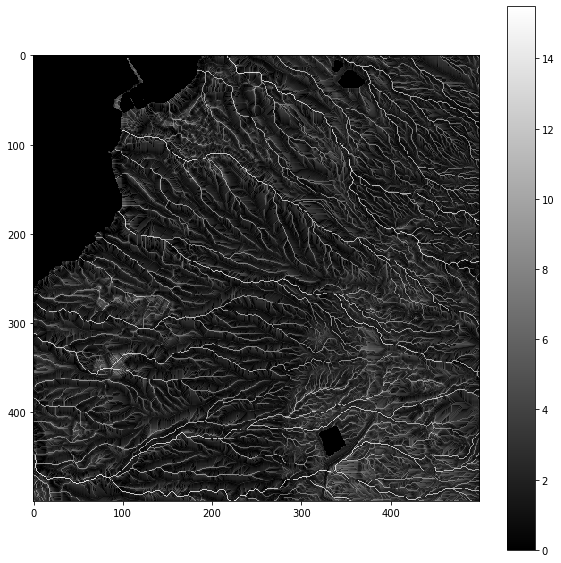

In [0]:
plt.figure(figsize = (10,10))
im = plt.imshow(wetnessindex[500:1000, 2000:2500], cmap = "gray", vmin=0)
plt.colorbar(im)
plt.show()

# STI（Sediment Transport Index; 輸送力指数）の計算

power(“FlowAccumulationArea_Raster”/22.13,0.6) * Power(Sin(“Slope_Raster”/0.0896),1.3)

In [0]:
slope_sin=np.deg2rad(slope_dg)

In [0]:
As=np.power(grid.acc/22.13,0.6)

In [0]:
Sn=np.power(np.sin(slope_sin)/0.0896,1.3)

In [0]:
Sti_temp=As*Sn
STI=Sti_temp.astype(np.float32)

In [0]:
grid.add_gridded_data(STI,data_name='STI',affine=grid.affine,crs=grid.crs)
grid.to_raster('STI',base_dir+'sti.tif',blockxsize=16,blockysize=16,view=False)

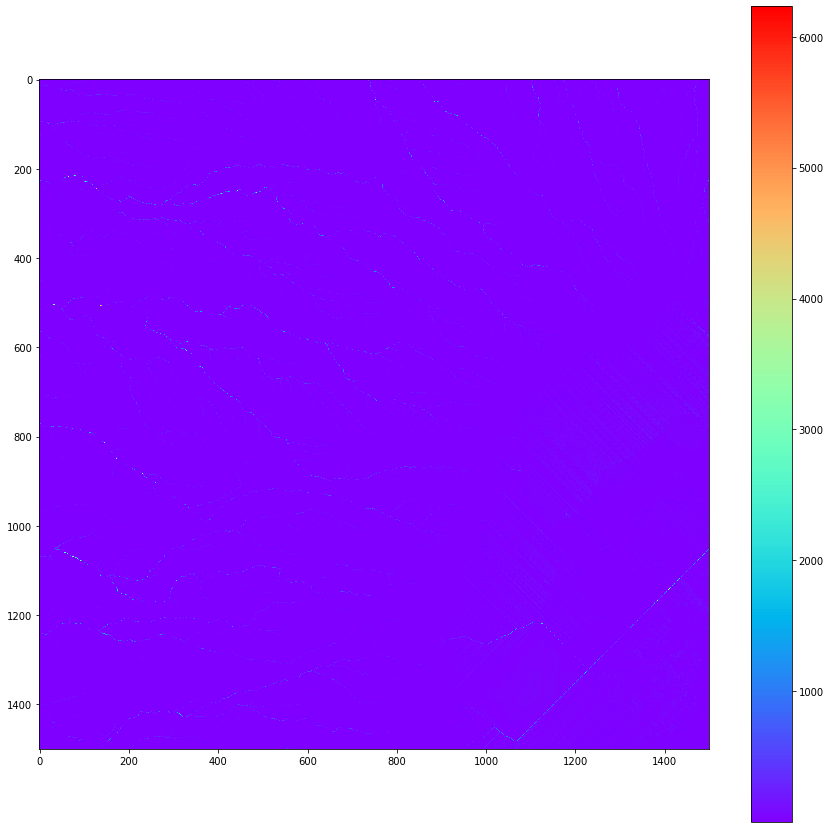

In [0]:
plt.figure(figsize=(15,15))
im=plt.imshow(STI[4000:5500,4000:5500],cmap="rainbow")
plt.colorbar(im)
plt.show()

In [0]:
plt.savefig('/content/drive/My Drive/soturon/STI.png')

<Figure size 432x288 with 0 Axes>